In [1]:
import db_model as dm

LAST_WEEK = 5

dm.create_tables()
dm.Constant.create(name='C',constant=0)
dm.Constant.create(name='K',constant=0)
dm.Constant.create(name='B1',constant=0)
dm.Constant.create(name='B2',constant=0)
dm.Constant.create(name='MAXRD',constant=0)

import update_rating as ur
from matplotlib import pyplot
import numpy as np

import update_teams
import update_matchscore

ur.initialize()


### I use annealing cause I have it implemented in an unrelated script and I can't be arsed to make something more suitable for the job. Sorry.

In [2]:
from ipywidgets import *
from IPython.display import display

divs = 26
state = [
         int(np.floor(divs/2)),
         int(np.floor(divs/2)),
         int(np.floor(divs/2)),
         int(np.floor(divs/2)),
         int(np.floor(divs/2))] #C, K, MAXRD, B1, B2
C_range = np.linspace(0,10,divs)
K_range = np.linspace(0,5,divs)
MAXRD_range = np.linspace(50,150,divs)
B1_range = np.linspace(0,1.5,divs)
B2_range = np.linspace(0,50,divs)

def state_to_constants(state):
    return [C_range[state[0]], K_range[state[1]], MAXRD_range[state[2]], B1_range[state[3]], B2_range[state[4]]]

def _anneal_step(temp, current_energy, neighbour_energy):
    if neighbour_energy < current_energy:
        return True
    elif np.random.rand() < np.exp((current_energy - neighbour_energy) / temp):
        return True
    else:
        return False
    
def anneal(initial_temp, temp_func, halt_temp, state, energy_func, neighbour_func):
    """Annealing algorithm. state is passed to energy_func and
    neighbour_func, and neighbour_func should generate a state object."""
    prog_disp = widgets.HTML(value='')
    display(prog_disp)
    
    data = {'time':[], 'energy':[], 'temp':[], 'min_time':[], 'min_energy':[], 'state':[]}
    time = 0
    min_energy = energy_func(state)
    min_state = state
    temp = initial_temp
    data['min_time'].append(time)
    data['min_energy'].append(min_energy)
    data['state'].append(state)
    while halt_temp < temp:
        temp = temp_func(time)
        neighbour = neighbour_func(state)
        current_energy = energy_func(state)
        neighbour_energy = energy_func(neighbour)
        if current_energy < min_energy:
            min_energy = current_energy
            data['min_time'].append(time)
            data['min_energy'].append(min_energy)
            min_state = state
        if _anneal_step(temp, current_energy, neighbour_energy):
            state = neighbour
        data['state'].append(state)
        data['time'].append(time)
        data['temp'].append(temp)
        data['energy'].append(current_energy)
        time = time + 1
        #if np.mod(time,2)==0:
        prog_disp.value = str(time) + ', ' + str(min_energy) + ', ' + str(temp) + ', ' + str(state_to_constants(min_state))+ ', ' + str(current_energy) + ', ' + str(state_to_constants(state))
    return (min_state, data)

def neighbour(state):
    new_state = state.copy()
    length = len(state)
    coord = np.random.randint(length)
    direction = np.random.randint(2)*2-1
    if new_state[coord]<abs(direction):
        direction = 1
    elif new_state[coord]>divs-abs(direction)-1:
        direction = -1
        
    new_state[coord] = state[coord]+direction
    return new_state

### All states go from 0 to 100, integer. They will be rescaled to fit the various parameters.

In [3]:
def energy(state):
    C_obj = dm.Constant.get(dm.Constant.name=='C')
    C_obj.constant = C_range[state[0]]
    C_obj.save()
    K_obj = dm.Constant.get(dm.Constant.name=='K')
    K_obj.constant = K_range[state[1]]
    K_obj.save()
    MAXRD_obj = dm.Constant.get(dm.Constant.name=='MAXRD')
    MAXRD_obj.constant = MAXRD_range[state[2]]
    MAXRD_obj.save()
    B1_obj = dm.Constant.get(dm.Constant.name=='B1')
    B1_obj.constant = B1_range[state[3]]
    B1_obj.save()
    B2_obj = dm.Constant.get(dm.Constant.name=='B2')
    B2_obj.constant = B2_range[state[4]]
    B2_obj.save()
    
    weeks = range(LAST_WEEK+1)
    teams = dm.Team.select()
    ur.initialize()
    for week in weeks:
        ur.update(week,5)
    
    matches = dm.Match.select()

    score = [0,0]
    squared_prediction_error = 0

    for week in range(2,LAST_WEEK+1):
        for day in range(1,6):
            matches = dm.Match.select().where(dm.Match.day == day, dm.Match.week == week)
            for match in matches:
                if day==1:
                    rating_day = 4
                    rating_week = week-1
                else:
                    rating_day = day-1
                    rating_week = week
                team1 = match.team1
                rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==rating_week).rating
                RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==rating_week).RD

                team2 = match.team2
                rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==rating_week).rating
                RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==rating_week).RD

                RD = np.sqrt(RD1**2+RD2**2)

                E = ur.E(RD, rating1, rating2)
                match_score = (match.wins+match.draws/2)/(match.wins+match.draws+match.losses)
                squared_prediction_error = squared_prediction_error+(match_score-E)**2
                if np.sign(match_score-0.5) == np.sign(E-0.5):
                    score[0] = score[0] + 1
                else:
                    score[1] = score[1] + 1
            ur.update(week,day)
    return squared_prediction_error+score[1]/5

In [4]:
def energy2(state):
    C_obj = dm.Constant.get(dm.Constant.name=='C')
    C_obj.constant = C_range[state[0]]
    C_obj.save()
    K_obj = dm.Constant.get(dm.Constant.name=='K')
    K_obj.constant = K_range[state[1]]
    K_obj.save()
    MAXRD_obj = dm.Constant.get(dm.Constant.name=='MAXRD')
    MAXRD_obj.constant = MAXRD_range[state[2]]
    MAXRD_obj.save()
    B1_obj = dm.Constant.get(dm.Constant.name=='B1')
    B1_obj.constant = B1_range[state[3]]
    B1_obj.save()
    B2_obj = dm.Constant.get(dm.Constant.name=='B2')
    B2_obj.constant = B2_range[state[4]]
    B2_obj.save()
    
    weeks = range(LAST_WEEK+1)
    teams = dm.Team.select()
    ur.initialize()
    for week in weeks:
        ur.update(week,5)
    
    matches = dm.Match.select()

    score = [0,0]
    squared_prediction_error = 0

    for week in range(2,LAST_WEEK+1):
        matches = dm.Match.select().where(dm.Match.week == week)
        for match in matches:
            team1 = match.team1
            rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).rating
            RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).RD

            team2 = match.team2
            rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).rating
            RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).RD

            RD = np.sqrt(RD1**2+RD2**2)

            E = ur.E(RD, rating1, rating2)
            match_score = (match.wins+match.draws/2)/(match.wins+match.draws+match.losses)
            matchscore_probability = (E**4, 4*E**3*(1-E),6*E**2*(1-E)**2*(E),6*E**2*(1-E)**2*(1-E), 4*(1-E)**3*E, (1-E)**4)
            exp_val = matchscore_probability[0]+matchscore_probability[1]*0.75+matchscore_probability[2]*0.6+\
                matchscore_probability[3]*0.4+matchscore_probability[4]*0.25
            squared_prediction_error = squared_prediction_error+(match_score-exp_val)**2
            if np.sign(match_score-0.5) == np.sign(E-0.5):
                score[0] = score[0] + 1
            else:
                score[1] = score[1] + 1
    return squared_prediction_error+score[1]/5

In [5]:
 def temperature(t):
    return 0.5/(1+0.0001*t**2)
(min_state,data) = anneal(1,temperature,0.001,state,energy2,neighbour)

HTML(value='')

In [8]:
print(min_state)

[22, 23, 7, 8, -1]


Text(0.5,1,'Energy')

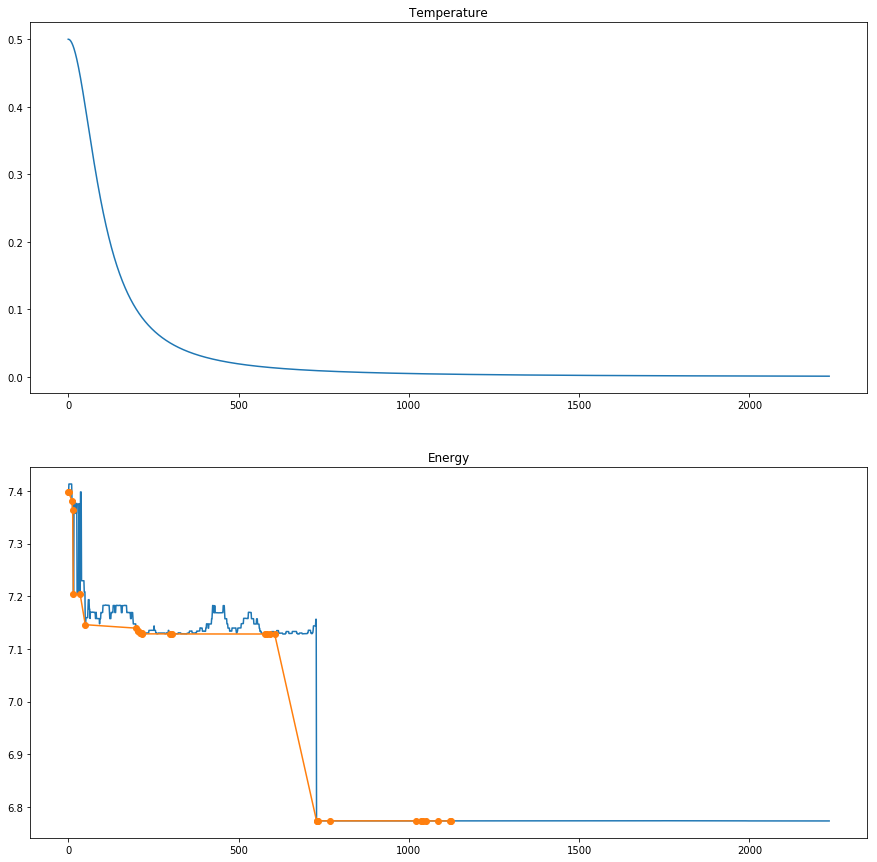

In [7]:
energy_data = [float(i) for i in data['energy']]
min_energy_data = [float(i) for i in data['min_energy']]

from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15,15)
plt.figure(1)
plt.subplot(211)
plt.plot(data['time'],data['temp'])
plt.title('Temperature')
plt.subplot(212)
plt.plot(data['time'],energy_data,data['min_time'],min_energy_data,'o-')
plt.title('Energy')


In [9]:
state_to_constants(min_state)

[8.8, 4.6000000000000005, 78.0, 0.48, 50.0]

In [5]:
energy([12, 16, 15, 11, 8])

4.5962836640398335

In [24]:
for rating in dm.Rating.select():
    print('{}: {}, {}'.format(rating.id, rating.rating, rating.RD))

1: 1500.0, 105.0
2: 1500.0, 105.0
3: 1500.0, 105.0
4: 1500.0, 105.0
5: 1500.0, 105.0
6: 1500.0, 105.0
7: 1500.0, 105.0
8: 1500.0, 105.0
9: 1500.0, 105.0
10: 1500.0, 105.0
11: 1500.0, 105.0
12: 1500.0, 105.0
13: 1624.091055997748, 94.33954831363437
14: 1538.3535867586804, 97.87281643286013
15: 1548.6122118837586, 97.34066221292545
16: 1500.0, 105.0
17: 1520.9590796480904, 98.01178389475628
18: 1545.0832022175052, 97.34066221292545
19: 1429.0848948966432, 97.61412283170746
20: 1523.3043598274066, 97.51528094174948
21: 1445.6385660686665, 94.43054587929463
22: 1396.6182387693825, 97.47737203603263
23: 1531.0295310293266, 97.54461591954814
24: 1404.6154364915365, 97.87281643286013
25: 1672.9545368942556, 89.2969392849109
26: 1597.6411573785617, 91.73099112093625
27: 1607.3940054086033, 92.37549893419727
28: 1441.021675434487, 97.67408792515855
29: 1446.534668902324, 91.92436826750769
30: 1676.471537653691, 97.70721963784499
31: 1485.7832689806523, 92.2092410910894
32: 1512.444319934805, 92